In [9]:
# Birth data exploration
# Matt Spencer - DataBard
# www.databard.blog
# 2/4/2018
library(dplyr)
library(tidyr)
library(ggplot2)
library(grid)
library(gridExtra)


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [10]:
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_line(colour="#f0f0f0"),
               panel.grid.minor = element_blank(),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

scale_fill_Publication <- function(...){
      library(scales)
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

scale_colour_Publication <- function(...){
      library(scales)
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

# Function to generate the copyright for any plot
# Useage:
# g <- ggplot(...) + ...
# add.copyright(g)
# add.copyright(g, 0.5, 1/20)
add.copyright <- function(plot, fontsize=1, rel.height=1/20) {
    cp <- textGrob(paste("\uA9 Matt Spencer ", format(Sys.time(), "%Y"), ", databard.blog", sep=''),
             gp=gpar(fontfamily = "Verdana", cex=fontsize) ,
             x=unit(1, "npc"), hjust = 1) #, y=unit(0, "npc"), vjust = 0)
    
    cp.h <- round(rel.height*100)
    plot.h <- 100-cp.h
    lay <- matrix(c(rep(1,plot.h), rep(2,cp.h)))
    
    return(grid.arrange(plot, cp, layout_matrix = lay))
}


In [11]:
data <- read.csv("data/sf_gestationdata.csv")

In [12]:
# data.filt is the filtered data
data.filt <- data %>% 
    filter(cesarean == 0, induced == 0, multiples == 1, previousbornonday != "NULL") %>%
    mutate(previousbornonday = as.numeric(as.character(previousbornonday))) %>%
    filter(bornonday >= 245, bornonday <= 301, previousbornonday >= 245, previousbornonday <= 301) %>%
    filter(previousbirths == 1) %>%
    select(IP.ID, bornonday, previousbornonday, motherbirthyear, grams, pounds, ounces, duedatebase)

In [13]:
# data.proc is the processed data with all values
# needed to plot the figure below.
data.proc <- data.filt %>%
    mutate(diff = bornonday - previousbornonday) %>%
    arrange(previousbornonday, diff) %>%
    mutate(dir = diff / abs(diff), id=row_number())
data.proc$dir[is.na(data.proc$dir)] <- 0

In [14]:
# Compare to https://spacefem.com/pregnant/charts/duedate5.php
data.proc %>%
    mutate(early = ifelse(previousbornonday < 280, 1, 0)) %>%
    group_by(early) %>%
    summarize(n = length(diff), mean = mean(diff), med = median(diff), sd = sd(diff))
(0-5.138889)/10.678788

early,n,mean,med,sd
0,124,-3.588710,-3,7.882276
1,144,5.138889,4,10.678788


[1] -0.481224

TableGrob (100 x 1) "arrange": 2 grobs
  z             cells    name               grob
1 1 (  1- 95,  1-  1) arrange     gtable[layout]
2 2 ( 96-100,  1-  1) arrange text[GRID.text.78]

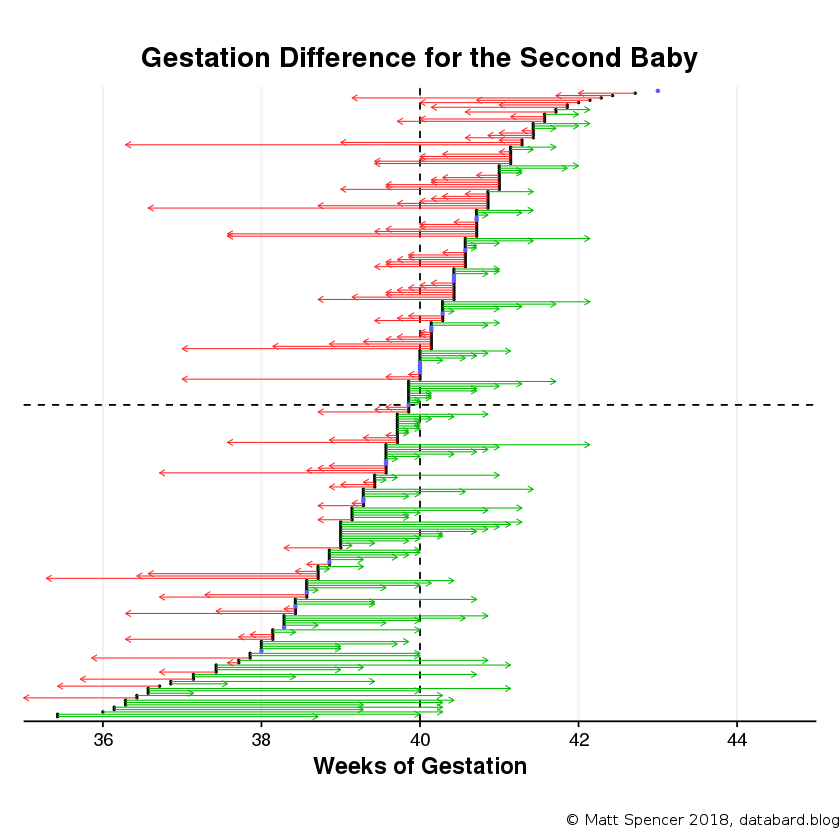

In [17]:
size.scale <- 0.6 
    # I use this global adjustment to all sizes because it is hard to 
    # know how the sizes will change when you save as an image file,
    # but I want the indicated sizes to be rougly the same ratio. This
    # lets me adjust all of them at once, if I think everything needs
    # to be larger or smaller.
change.plot <- data.proc %>%
    filter(dir != 0) %>%
    ggplot(aes(x = previousbornonday, y = id)) +
    geom_vline(xintercept = 280, linetype = 2) +
    geom_hline(yintercept = nrow(data.proc) / 2, linetype = 2) +
    geom_point(size = 0.5 * size.scale) +
    geom_segment(aes(xend = bornonday, yend = id, color = factor(dir)), 
                 size = 0.5 * size.scale, arrow = arrow(length = unit(0.01, "npc"))) +
    geom_point(data = data.proc[data.proc$dir == 0,], color = "#5c5cff", size = size.scale) +
    scale_color_manual(values = c("#ff2929", "#00bd00")) +
    scale_x_continuous(limits = c(245, 315), breaks = seq(252, 308, 14), 
                       minor_breaks = seq(245, 315, 14), labels = seq(36, 44, 2), expand = c(0, 0)) +
    xlab("Weeks of Gestation") +
    scale_y_continuous(expand = c(0, 2), breaks = NULL) +
    ggtitle("Gestation Difference for the Second Baby") +
    theme_Publication() +
    theme( 
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.line.y = element_blank(),
        legend.position = "none"
        )
change.plot <- add.copyright(change.plot, 0.75)
change.plot
ggsave(file = "figures/subsequent.gest.jpeg", change.plot, width = 5, height = 5, dpi = 300)